<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_06_auto_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [2]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1134 (delta 28), reused 5 (delta 2), pack-reused 1089
Receiving objects: 100% (1134/1134), 72.59 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (673/673), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
import pylab as pl
from collections import Counter

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.ensemble import RandomForestClassifier

# from scikitplot.plotters import plot_precision_recall_curve

from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

import xgboost as xgb

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labelled_scatter

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 5586M
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
total 25M
-rw-r--r-- 1 root root  1M Jan 13 14:02 4D.zip
-rw-r--r-- 1 root root 25M Jan 13 14:02 labels.csv


In [0]:
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 217 entries, NumberId to year
dtypes: datetime64[ns](1), float64(155), int64(59), uint8(2)
memory usage: 1.5 GB


## Exploratory Data Analysis

### View data

In [0]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [0]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)

In [13]:
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


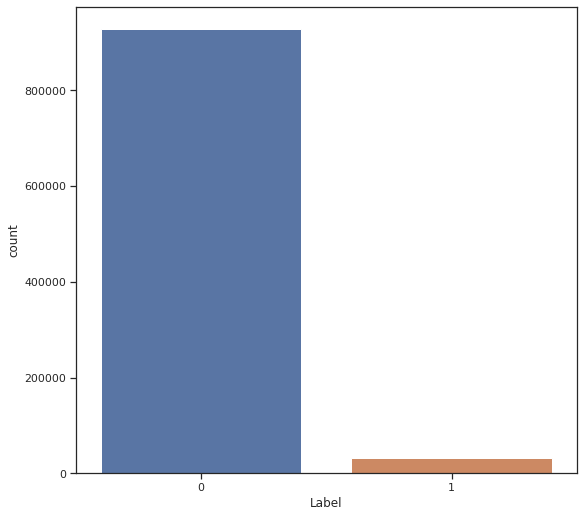

In [14]:
plt.figure(figsize=(8, 8))
sns.countplot('Label', data=feature_matrix)

In [15]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

In [16]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),LAST(Results.LuckyNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.PERCENTILE(TotalStrike)),...,CUM_MEAN(SUM(Results.TotalStrike)),CUM_MEAN(STD(Results.TotalStrike)),CUM_MEAN(SKEW(Results.TotalStrike)),CUM_MEAN(SUM(Results.DrawNo)),"CUM_MEAN(TREND(Results.DrawNo, DrawDate))",CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(MAX(Results.LuckyNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(SUM(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
363,2012-01-01,101777.042238,0.0,0.0,323109,1,19,40792,1,19,178621.785714,1,19,0.070113,0.0,0.0,64949,323109,1,19,4.214991e+07,14,2500705,14,266,0.0,0.0,0.03093,1,5,6,620265540.0,NaN,1.974207e+08,50881.655504,1.165405e+08,0.315275,23963.048477,23409.008640,0.0,...,14.000000,0.0,0.0,2.500705e+06,0.03093,19.000000,19.000000,9,16,0.500051,0.001201,0.256328,0.50005,0.392496,0.50005,0.500051,0.50005,0.50005,0.056537,0.002001,0.392496,0.985643,0.002001,0.004502,0.50005,0.50005,0.696425,0.548813,0.500051,0.985643,0.50005,0.500051,0.937769,0.200471,0.002001,0.002001,0.0,0,1,1
9017,2012-01-01,126014.206582,0.0,0.0,317909,1,123,139698,1,123,228803.500000,1,123,NaN,NaN,NaN,63742,317909,1,123,3.393792e+08,2,457607,2,246,NaN,NaN,NaN,1,8,29,421027140.0,259200.0,2.399773e+08,63009.063553,1.443593e+08,0.390354,0.000000,28985.721174,0.0,...,7.681889,0.0,NaN,1.524155e+06,NaN,5002.374694,5002.374694,5,31,NaN,0.898299,0.772186,0.50005,0.348174,0.50005,NaN,0.50005,0.50005,0.996485,0.012406,0.348174,0.013057,0.012406,0.003902,0.50005,0.50005,0.962392,NaN,NaN,0.013057,0.50005,NaN,0.026213,NaN,0.012406,0.012406,0.0,0,1,1
8619,2012-01-01,139944.917278,0.0,0.0,322109,1,135,124197,1,135,223153.000000,1,135,NaN,NaN,NaN,64702,322109,1,135,3.782592e+08,2,446306,2,270,NaN,NaN,NaN,1,8,31,452390340.0,0.0,2.674696e+08,69939.255825,1.603340e+08,0.433508,0.000000,32173.358544,0.0,...,7.738201,0.0,NaN,1.524989e+06,NaN,4988.969509,4988.969509,8,26,NaN,0.856378,0.721761,0.50005,0.383192,0.50005,NaN,0.50005,0.50005,0.997791,0.013607,0.383192,0.013057,0.013607,0.004702,0.50005,0.50005,0.990259,

### Data Cleansing

In [0]:
## Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [18]:
feature_matrix.isna().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                  0
SKEW(Results.TIME_SINCE(DrawDate))             0
MEAN(Results.CUM_MEAN(TotalStrike))            0
MEAN(Results.CUM_MEAN(LuckyNo))                0
MEAN(Results.CUM_SUM(DrawNo))                  0
                                              ..
CUM_SUM(COUNT(Results))                        0
CUM_SUM(MAX(Results.DrawNo))                   0
CUM_SUM(MEAN(Results.LuckyNo))                 0
CUM_SUM(AVG_TIME_BETWEEN(Results.DrawDate))    0
time                                           0
Length: 214, dtype: int64

In [19]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),LAST(Results.LuckyNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.PERCENTILE(TotalStrike)),...,CUM_MEAN(SUM(Results.TotalStrike)),CUM_MEAN(STD(Results.TotalStrike)),CUM_MEAN(SKEW(Results.TotalStrike)),CUM_MEAN(SUM(Results.DrawNo)),"CUM_MEAN(TREND(Results.DrawNo, DrawDate))",CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(MAX(Results.LuckyNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(SUM(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize


### Feature Selection

In [0]:
# Feature scaling first??

In [21]:
print(feature_matrix.shape)
feature_matrix.columns

(959893, 214)


Index(['time', 'STD(Results.DrawNo)', 'STD(Results.TotalStrike)',
       'STD(Results.LuckyNo)', 'MAX(Results.DrawNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.LuckyNo)',
       'MIN(Results.DrawNo)', 'MIN(Results.TotalStrike)',
       'MIN(Results.LuckyNo)',
       ...
       'PERCENTILE(STD(Results.TotalStrike))',
       'PERCENTILE(SKEW(Results.TotalStrike))',
       'PERCENTILE(SUM(Results.DrawNo))',
       'PERCENTILE(TREND(Results.DrawNo, DrawDate))',
       'PERCENTILE(LAST(Results.LuckyNo))', 'PERCENTILE(MAX(Results.LuckyNo))',
       'TotalStrike', 'Label', 'MODE(Results.PrizeType)_Prize',
       'LAST(Results.PrizeType)_Prize'],
      dtype='object', length=214)

In [22]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [25]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 64),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [0]:
# Check without feature selection
# corrs = feature_matrix.corr().sort_values('Label')
# corrs['Label'].tail(100)

In [28]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')
corrs['Label'].tail(20)

SUM(Results.TIME_SINCE_PREVIOUS(DrawDate))      0.000442
MODE(Results.DAY(DrawDate))                     0.000471
PERCENTILE(SUM(Results.DrawNo))                 0.000610
TREND(Results.PERCENTILE(LuckyNo), DrawDate)    0.000687
MONTH(first_Results_time)                       0.000858
PERCENTILE(TREND(Results.DrawNo, DrawDate))     0.000912
MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))      0.000984
TIME_SINCE_PREVIOUS(first_Results_time)         0.000987
LAST(Results.CUM_MEAN(LuckyNo))                 0.000988
MAX(Results.CUM_MEAN(LuckyNo))                  0.001007
MEAN(Results.PERCENTILE(DrawNo))                0.001149
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)      0.001493
TREND(Results.PERCENTILE(DrawNo), DrawDate)     0.001528
PERCENTILE(MAX(Results.TotalStrike))            0.001564
MIN(Results.DrawNo)                             0.001718
CUM_SUM(MIN(Results.DrawNo))                    0.001852
MAX(Results.PERCENTILE(TotalStrike))            0.002320
STD(Results.CUM_MEAN(LuckyNo)) 

### Balancing data

In [0]:
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss)
from imblearn.combine import SMOTETomek

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value=0)), ('scaler', StandardScaler())])

In [0]:
def under_sampling_test(feature_data, cut_off_date, ratio=0.8):
  y = feature_data.loc[feature_data['time'] < cut_off_date, 'Label']
  X = feature_data[feature_data['time'] < cut_off_date].drop(columns = ['Label', 'TotalStrike','time','date'], errors='ignore')
  total_count = y.value_counts()
  neg_count = y.value_counts()[0]
  pos_count = y.value_counts()[1]
  target_neg_count = int(pos_count / (1-ratio))
  target_ratio = {0: target_neg_count, 1:  pos_count}
  print(X.shape, y.shape, target_ratio)
  # print('Before sampling {}'.format(Counter(y)))
  sampler = RandomUnderSampler(sampling_strategy=target_ratio, random_state=42)
  X_bal, y_bal = sampler.fit_sample(X, y)
  print('Undersampling {}'.format(Counter(y_bal)))
  return X_bal, y_bal

def over_under_sampling_test(feature_data, cut_off_date, ratio=0.8):
  y = feature_data.loc[feature_data['time'] < cut_off_date, 'Label']
  X = feature_data[feature_data['time'] < cut_off_date].drop(columns = ['Label', 'TotalStrike','time','date'], errors='ignore')
  print('Before sampling {}'.format(Counter(y)))
  sampler = SMOTETomek(sampling_strategy='auto')
  X = pipeline.fit_transform(X)
  X_bal, y_bal = sampler.fit_sample(X, y)
  print('Over and undersampling {}'.format(Counter(y_bal)))
  return X_bal, y_bal

X_res, y_res = over_under_sampling_test(feature_matrix_selection, pd.datetime(2019,6,1))

Before sampling Counter({0: 860060, 1: 29833})


In [0]:
def plot_this(X_rs,y_rs,method):
  # Use principal component to condense the 10 features to 2 features
  pca = PCA(n_components=2).fit(X_rs)
  pca_2d = pca.transform(X_rs)
  # Assign colors
  for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 0:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='o')
    elif y_rs[i] == 1:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='*')  
  pl.legend([c1, c2], ['Class 1', 'Class 2'])
  pl.title(method)
  pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
  pl.show()

# Plot 
plot_this(X_res, y_res, 'SMOTETomek')

In [0]:
def under_sampling(X, y, ratio=0.9):
  total_count = y.value_counts()
  neg_count = y.value_counts()[0]
  pos_count = y.value_counts()[1]

  target_neg_count = int(pos_count / (1-ratio))
  target_ratio = {0: target_neg_count, 1:  pos_count}
  #print(X.shape, y.shape, target_ratio)
  print('Before sampling {}'.format(Counter(y)))
  sampler = RandomUnderSampler(random_state=42, sampling_strategy=target_ratio)
  X_bal, y_bal = sampler.fit_sample(X, y)
  print('Undersampling {}'.format(Counter(y_bal)))
  return X_bal, y_bal

def over_under_sampling(X, y):
  pass

## Modeling

In [0]:
def predict(dt, feature_matrix, sampling = False, return_probs = False): 
   
    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
   
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value=0)), ('scaler', StandardScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # Balance the data
    if sampling:
      X_train, train_labels = under_sampling(X_train, train_labels)
   
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    # https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    # https://stats.stackexchange.com/questions/224512/reduce-false-positives-with-xgboost

    if type(train_labels) == np.ndarray:
      hit_ratio = float( len(np.where(train_labels == 0)[0]) / len(np.where(train_labels == 1)[0]) ) 
    else:
      hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1]) 
    print(f"Hit ratio - {hit_ratio}\n")

     # Create the classifier
    model = xgb.XGBClassifier(n_jobs=-1, 
                             random_state = 42,
                             n_estimators=100, 
                             max_depth=3,
                             objective='binary:logistic',
                             min_child_weight=1,
                             scale_pos_weight=hit_ratio 
                             )

    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    # Total positive
    positive = np.where((predictions==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')
  
    # Calculate metrics
    rpt = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    print('Classification report')
    print(rpt)
    print(f'Confusion matrix:\n {cm}\n')

    # Total predicted matches
    print('Predicted matches')
    pred = np.where((predictions==1))
    print(len(pred[0]), pred[0][0:23])
    topN = np.argpartition(probs, -23)[-23:]
    print(f'\n{topN}\n')  # Top N most high probability numbers
  
    if len(positive[0]) > 0:
    
      # Matching draws
      print('Matched draws')
      md = np.where((predictions==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['date'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi

In [35]:
%time june_2019 = predict(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Hit ratio - 28.829148929038315

Total predicted to be positive: 1163 

Classification report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      9664
           1       0.03      0.11      0.05       336

    accuracy                           0.86     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.93      0.86      0.89     10000

Confusion matrix:
 [[8538 1126]
 [ 299   37]]

Predicted matches
1163 [ 15  19  20  36  38  44  52  66  72  75  95 104 107 111 117 130 142 148
 151 152 157 160 171]

[2326 5045 2029 6874 1949 3754 3114 8690 4897   19  160 3870 9237 4027
 4478 9456  823 9994 3250 1271 6220 5311 4562]

Matched draws
Count: 37, Index: (array([  15,   44,  217,  397,  511,  558, 1218, 1253, 1381, 1495, 1904,
       2044, 2133, 2169, 

In [0]:
#normalized_fi = plot_feature_importances(june_2019)

In [0]:
# Loop through from June to Dec
# start_mt = pd.datetime(2019,6,1)
# how_many_mt = 7
# for i in range(how_many_mt):
#   month_to_predict = start_mt + relativedelta(months=i)
#   print(f"\n{month_to_predict}\n-------------------\n")
#   %time predict(month_to_predict, feature_matrix_selection)